In [2]:
'''
In this notebook i will select data from a specific area and time period. Lets use the data from 2015 to 2025 and 
the area of 18N to 22N and 91W to 86W. For that time period, i want to know how correlated is the temperature in that area 
with another grid points, Also i want to know how correlated is the precipitation in that area with another grid points.
Finally i want to know how is the covariance between temperature and precipitation in that area.

Daniela Risaro
July 2025
'''

import os 
import numpy as np 
import xarray as xr 
import pandas as pd 


## select data from 2015 to 2025 and 18N to 22N and 91W to 86W.

data_dir = "../data/raw/"
output_dir = "../data/processed/"

os.makedirs(output_dir, exist_ok=True)

files_temperature = sorted([file for file in os.listdir(data_dir) if file.endswith(".nc") and "tmax" in file])
files_precipitation = sorted([file for file in os.listdir(data_dir) if file.endswith(".nc") and "precipitation" in file])

wanted_years = list(range(2015, 2026))

lat_min, lat_max = 18, 22 
lon_min, lon_max = -91, -86  

temp_datasets = [xr.open_dataset(data_dir + f) for f in files_temperature 
                if int(f.split("_")[-1].split(".")[0]) in wanted_years]
temperature = xr.concat(temp_datasets, dim="valid_time")
temperature = temperature["t2m"] - 273.15

precip_datasets = [xr.open_dataset(data_dir + f) for f in files_precipitation 
                  if int(f.split("_")[-1].split(".")[0]) in wanted_years]
precipitation = xr.concat(precip_datasets, dim="valid_time")
precipitation = precipitation["tp"]  

temp_region = temperature.sel(
    latitude=slice(lat_max, lat_min),
    longitude=slice(lon_min, lon_max),
    valid_time=slice("2015-01-01", "2025-06-30")
)

precip_region = precipitation.sel(
    latitude=slice(lat_max, lat_min),
    longitude=slice(lon_min, lon_max), 
    valid_time=slice("2015-01-01", "2025-06-30")
)



In [3]:
import matplotlib.pyplot as plt

ref_lat = 20.645092
ref_lon = -87.085771

ref_temp = temp_region.sel(latitude=ref_lat, longitude=ref_lon, method='nearest')
ref_precip = precip_region.sel(latitude=ref_lat, longitude=ref_lon, method='nearest')

print(f"Actual grid point coordinates used:")
print(f"Latitude: {float(ref_temp.latitude.values):.3f}°N")
print(f"Longitude: {float(ref_temp.longitude.values):.3f}°W")

temp_correlations = xr.corr(ref_temp, temp_region, dim='valid_time')

#precip_correlations = xr.corr(ref_precip, precip_region, dim='valid_time')



Actual grid point coordinates used:
Latitude: 20.750°N
Longitude: -87.000°W


In [4]:
from scipy import stats

precip_correlations = xr.zeros_like(precip_region.isel(valid_time=0))

ref_precip_values = ref_precip.values

for lat in precip_region.latitude:
    for lon in precip_region.longitude:
        target_precip = precip_region.sel(latitude=lat, longitude=lon)
        target_precip_values = target_precip.values
        
        rho, _ = stats.spearmanr(ref_precip_values, target_precip_values, nan_policy='omit')
        
        precip_correlations.loc[dict(latitude=lat, longitude=lon)] = rho

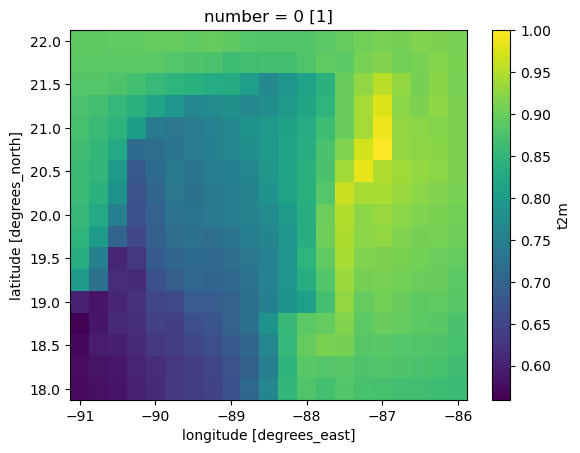

In [5]:
temp_correlations.plot()

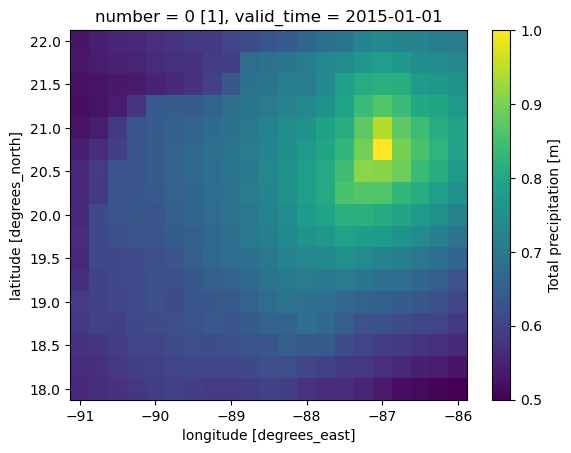

In [6]:
precip_correlations.plot()

In [7]:
import pandas as pd

# Create a DataFrame with the time series at the reference point
df = pd.DataFrame({
    'date': ref_temp.valid_time.values,
    'temperature': ref_temp.values,
    'precipitation': ref_precip.values
})

# Sort by date just to be sure
df = df.sort_values('date')

# Export to CSV
output_path = '../outputs/tulum_temp_precip_timeseries.csv'
df.to_csv(output_path, index=False)

print(f"Data exported to: {output_path}")
print("\nFirst few rows of the data:")
print(df.head())

Data exported to: ../outputs/tulum_temp_precip_timeseries.csv

First few rows of the data:
        date  temperature  precipitation
0 2015-01-01    27.231354       0.000147
1 2015-01-02    27.373688       0.000154
2 2015-01-03    27.882965       0.000223
3 2015-01-04    27.771881       0.000277
4 2015-01-05    27.114166       0.000121


<Axes: >

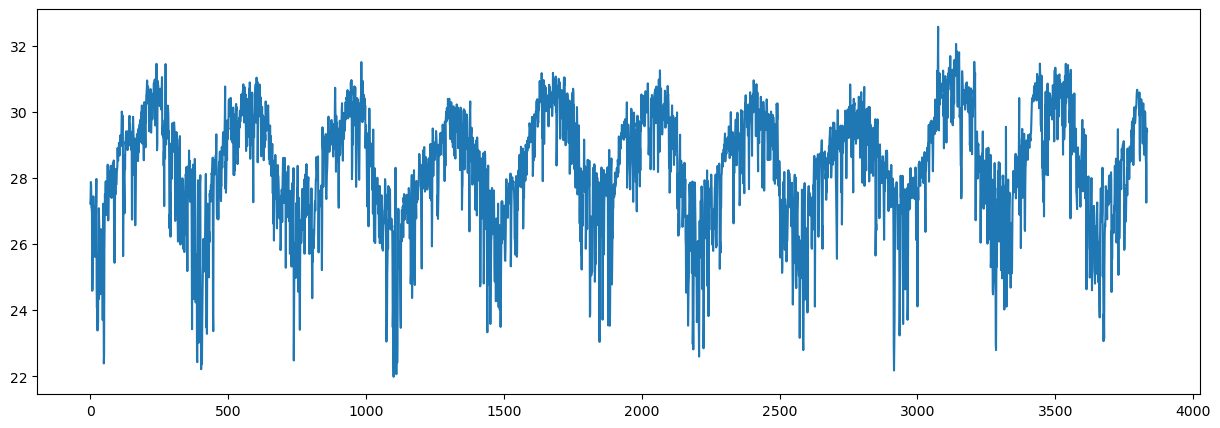

In [8]:
df['temperature'].plot(figsize=(15, 5))

<Axes: >

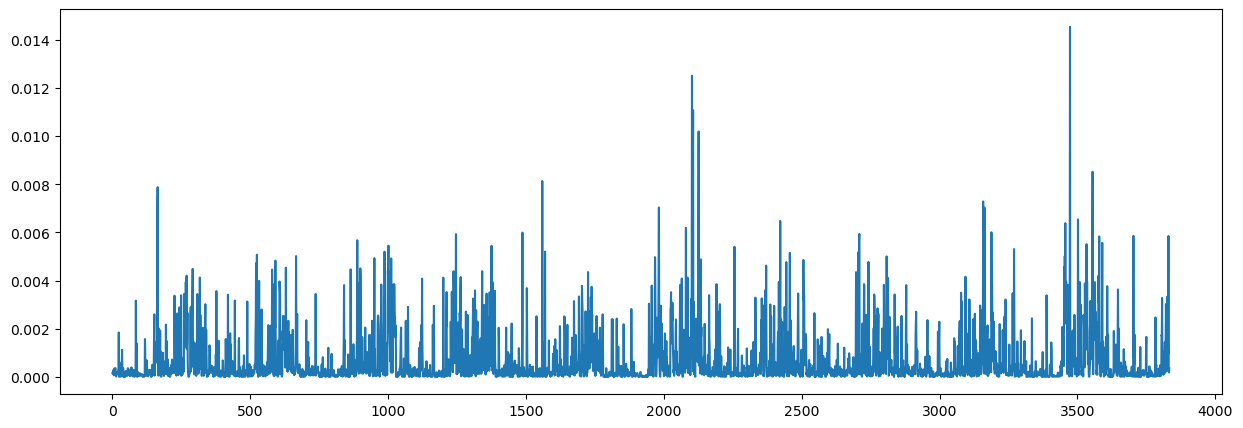

In [9]:
df['precipitation'].plot(figsize=(15, 5))

Precipitation Analysis:
Total number of records: 3834

Precipitation Statistics:

All precipitation values:
count    3834.000000
mean        0.000675
std         0.001121
min         0.000000
25%         0.000074
50%         0.000212
75%         0.000717
max         0.014546
Name: precipitation, dtype: float64

Non-zero precipitation values:
count    3.701000e+03
mean     6.990999e-04
std      1.133880e-03
min      4.768372e-07
25%      8.916855e-05
50%      2.250671e-04
75%      7.581711e-04
max      1.454639e-02
Name: precipitation, dtype: float64

Log10(Non-zero precipitation):
count    3701.000000
mean       -3.655348
std         0.762615
min        -6.321630
25%        -4.049788
50%        -3.647688
75%        -3.120233
max        -1.837245
Name: precipitation, dtype: float64

Correlations:
Temperature vs Precipitation (all data): 0.045
Temperature vs Log10(Precipitation) (non-zero only): 0.105


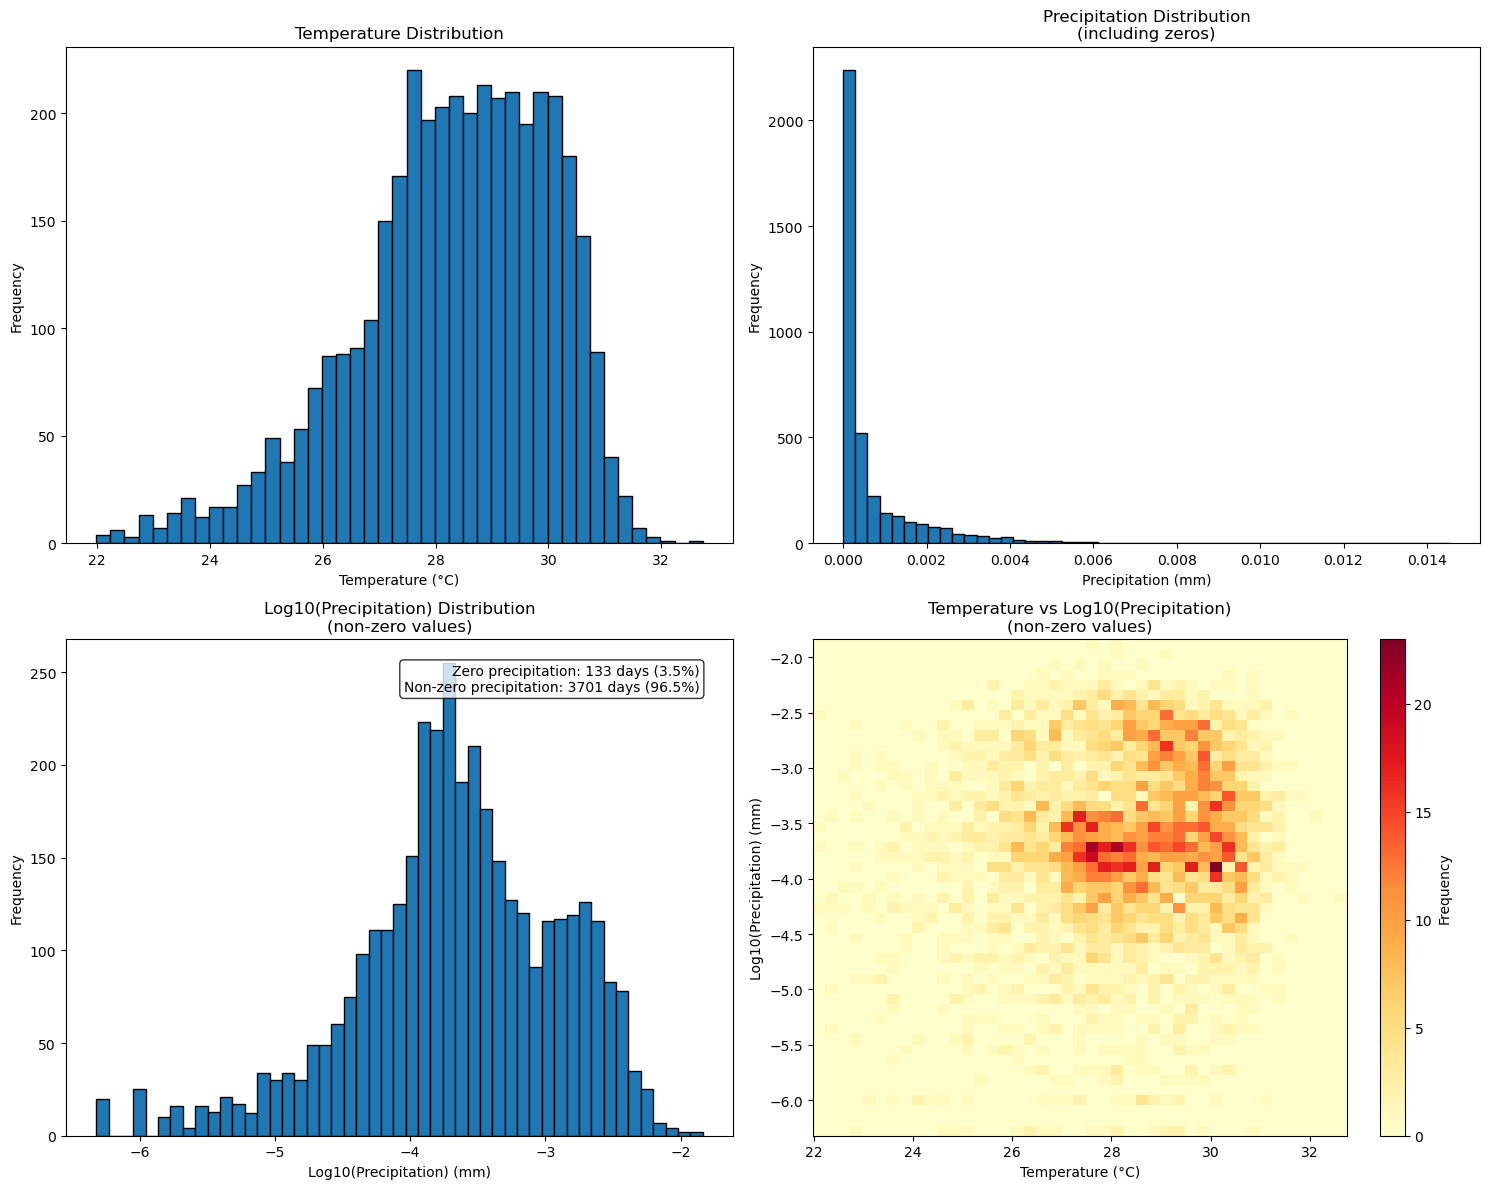

In [13]:
# Analyze precipitation patterns
print("Precipitation Analysis:")
print(f"Total number of records: {len(df)}")

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# 1. Temperature distribution (top left)
bins_temp = np.arange(df['temperature'].min(), df['temperature'].max() + 0.25, 0.25)
axes[0,0].hist(df['temperature'].dropna(), bins=bins_temp, edgecolor='black')
axes[0,0].set_title('Temperature Distribution')
axes[0,0].set_xlabel('Temperature (°C)')
axes[0,0].set_ylabel('Frequency')

# 2. Original Precipitation Distribution (top right)
non_zero_precip = df[df['precipitation'] > 0]
axes[0,1].hist(df['precipitation'], bins=50, edgecolor='black')
axes[0,1].set_title('Precipitation Distribution\n(including zeros)')
axes[0,1].set_xlabel('Precipitation (mm)')
axes[0,1].set_ylabel('Frequency')

# 3. Log-transformed Precipitation (bottom left)
log_non_zero = np.log10(non_zero_precip['precipitation'])
bins_log_precip = np.linspace(log_non_zero.min(), log_non_zero.max(), 50)
axes[1,0].hist(log_non_zero, bins=bins_log_precip, edgecolor='black')
axes[1,0].set_title('Log10(Precipitation) Distribution\n(non-zero values)')
axes[1,0].set_xlabel('Log10(Precipitation) (mm)')
axes[1,0].set_ylabel('Frequency')

# Add text box with precipitation statistics
zero_count = len(df[df['precipitation'] == 0])
text = (f'Zero precipitation: {zero_count} days ({zero_count/len(df)*100:.1f}%)\n'
        f'Non-zero precipitation: {len(non_zero_precip)} days ({len(non_zero_precip)/len(df)*100:.1f}%)')
axes[1,0].text(0.95, 0.95, text, transform=axes[1,0].transAxes, 
               verticalalignment='top', horizontalalignment='right',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Temperature vs Precipitation Relationships (bottom right)
h = axes[1,1].hist2d(non_zero_precip['temperature'], log_non_zero, 
                     bins=[bins_temp, bins_log_precip], cmap='YlOrRd')
axes[1,1].set_title('Temperature vs Log10(Precipitation)\n(non-zero values)')
axes[1,1].set_xlabel('Temperature (°C)')
axes[1,1].set_ylabel('Log10(Precipitation) (mm)')
plt.colorbar(h[3], ax=axes[1,1], label='Frequency')

plt.tight_layout()

# Print statistics
print("\nPrecipitation Statistics:")
print("\nAll precipitation values:")
print(df['precipitation'].describe())
print("\nNon-zero precipitation values:")
print(non_zero_precip['precipitation'].describe())
print("\nLog10(Non-zero precipitation):")
print(log_non_zero.describe())

# Calculate correlations both ways
corr_all = df['temperature'].corr(df['precipitation'])
corr_non_zero = non_zero_precip['temperature'].corr(log_non_zero)
print("\nCorrelations:")
print(f"Temperature vs Precipitation (all data): {corr_all:.3f}")
print(f"Temperature vs Log10(Precipitation) (non-zero only): {corr_non_zero:.3f}")


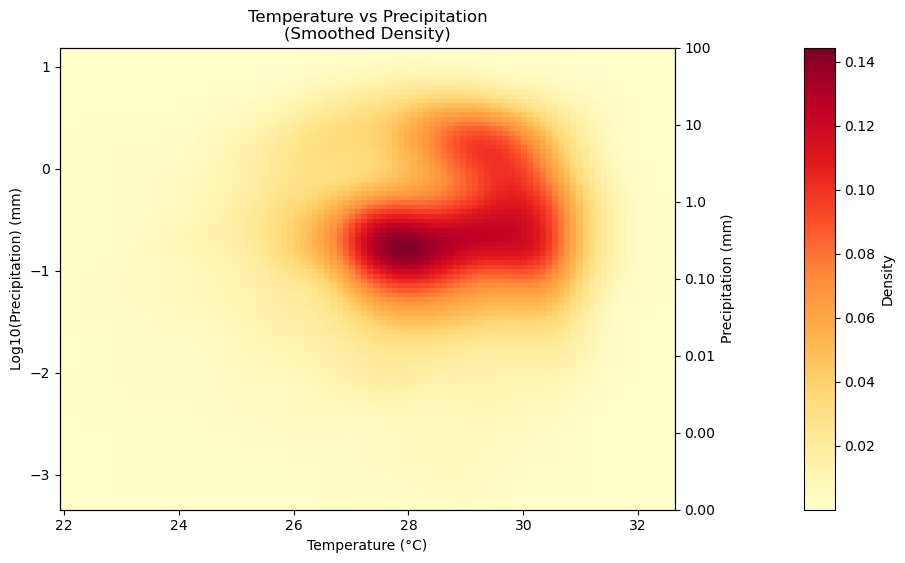

In [20]:
fig = plt.figure(figsize=(10, 6))
gs = plt.GridSpec(1, 2, width_ratios=[20, 1])
ax1 = fig.add_subplot(gs[0])
cax = fig.add_subplot(gs[1])

# Convert precipitation to mm
log_non_zero_mm = np.log10(non_zero_precip['precipitation'] * 1000)

x_grid = np.linspace(non_zero_precip['temperature'].min(), 
                     non_zero_precip['temperature'].max(), 100)
y_grid = np.linspace(log_non_zero_mm.min(), log_non_zero_mm.max(), 100)
X, Y = np.meshgrid(x_grid, y_grid)

xy = np.vstack([non_zero_precip['temperature'], log_non_zero_mm])
kde = gaussian_kde(xy, bw_method='scott')

positions = np.vstack([X.ravel(), Y.ravel()])
Z = kde(positions).reshape(X.shape)

im = ax1.pcolormesh(X, Y, Z, shading='auto', cmap='YlOrRd')
ax1.set_title('Temperature vs Precipitation\n(Smoothed Density)')
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('Log10(Precipitation) (mm)')

ax2 = ax1.twinx()
y_min, y_max = ax1.get_ylim()

log_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + 1)
real_values = 10**log_ticks  # These are now in mm

ax2.set_ylim(ax1.get_ylim())
ax2.set_ylabel('Precipitation (mm)')

tick_labels = []
for v in real_values:
    if v < 1:
        tick_labels.append(f'{v:.2f}')
    elif v < 10:
        tick_labels.append(f'{v:.1f}')
    else:
        tick_labels.append(f'{int(v)}')

ax2.set_yticks(log_ticks)
ax2.set_yticklabels(tick_labels)

plt.colorbar(im, cax=cax, label='Density')
plt.subplots_adjust(wspace=0.4)
